In [82]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn import cross_validation
from scipy.stats import spearmanr
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook


__author__ = 'amanda'


# load geometric features
def load_geo():
    geometric_all = pd.read_csv('../clean_data/geometric_all.csv')

    x = geometric_all.drop(['imgName', 'Unnamed: 0', 'attractive'], axis=1)

    field_names = list(x.columns.values)
    feature_x = x.values
    feature_x = preprocessing.scale(feature_x)  # normalize the feature matrix.

    attract_y = geometric_all['attractive'].values
    return feature_x, attract_y, field_names


def ridge_regression(X, y):
    itr_num = 50
    test_corr_list = np.zeros((itr_num, 1))
    coef_list = np.zeros((X.shape[1], itr_num))

    alphas = np.logspace(-3, 2, num=20)

    for cur_itr in range(itr_num):
        x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)
        clf = linear_model.RidgeCV(alphas=alphas, fit_intercept=True)
        clf.fit(x_train, y_train)

        y_test_pred = clf.predict(x_test)

        corr = spearmanr(y_test, y_test_pred)
        test_corr_list[cur_itr] = corr[0]

        coef_list[:, cur_itr] = clf.coef_

    return test_corr_list.mean(), coef_list


def plot_bar_graph(coef_list, field_names):
    coef_mean = coef_list.mean(axis=1)
    coef_std = coef_list.std(axis=1)/np.sqrt(len(coef_mean))

    # plot
    n = len(coef_mean)  # number of data entries
    ind = np.arange(n)  # the x locations for the groups
    width = 0.35  # bar width

    fig, ax = plt.subplots(figsize=(16, 12))

    rects1 = ax.bar(ind, coef_mean,                  # data
                    width,                          # bar width
                    color='MediumSlateBlue',        # bar colour
                    yerr=coef_std,                  # data for error bars
                    error_kw={'ecolor': 'Tomato',    # error-bars colour
                              'linewidth': 2})       # error-bar width

    def autolabel(rects):
        i = 0
        for rect in rects:
            height = coef_mean[i]
            ax.text(rect.get_x() + rect.get_width()/2., 1.15*height,
                    '%.2f' % float(height),
                    ha='center',            # vertical alignment
                    va='bottom'             # horizontal alignment
                    )
            i += 1
        return

    autolabel(rects1)
    axes = plt.gca()
    axes.set_ylim([-0.5, 0.5])

    ax.set_ylabel('Coefficients', fontsize=20)
    ax.set_title('Coefficients of all geometric features', fontsize=20)

    ax.set_xticks(ind + width)
    ax.set_xticklabels(field_names, rotation=90)
    plt.tick_params(labelsize=18)
    plt.savefig('../figs/geometric_feature_bar_graph.png')
    plt.show()
    return


def plot_bar_pipeline():
    feature_x, attract_y, field_names = load_geo()
    test_corr_mean, coef_list = ridge_regression(feature_x, attract_y)
    print test_corr_mean
    plot_bar_graph(coef_list, field_names)
    return


def simple_pca(feature_x):
    pca = PCA()
    pca_feat = pca.fit_transform(feature_x)
    pca_score = pca.explained_variance_ratio_
    pca_component = pca.components_
    return pca_feat, pca_score, pca_component


In [ ]:
feature_x, attract_y, field_names = load_geo()
pca_feat, pca_score, pca_component = simple_pca(feature_x)
test_error_list = np.zeros((pca_feat.shape[1], 1))

for cur_feat_num in range(pca_feat.shape[1]):
    print cur_feat_num
    cur_x = pca_feat[:, :cur_feat_num+1]
    corr_mean, _ = ridge_regression(cur_x, attract_y)
    test_error_list[cur_feat_num] = corr_mean

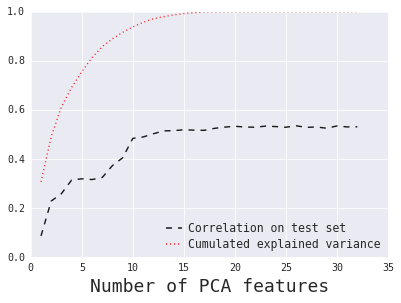

In [85]:
# plot
n = len(test_error_list)
x = np.arange(1, n+1)

fig, ax = plt.subplots()
ax.plot(x, test_error_list, 'k--', alpha=0.9, label='Correlation on test set')
ax.plot(x, pca_score.cumsum(), 'r:', alpha=0.9, label='Cumulated explained variance')

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Number of PCA features', fontsize=18)

fig.savefig('../figs/corr_var_featNum_geometric.jpg')
plt.show()